In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import multiseg as ms
import pandas as pd
import numpy as np
%matplotlib inline 
from IPython.display import display, Markdown
import glob
import matplotlib.pyplot as plt

## problem with projection
import os
os.environ["PROJ_LIB"] = r"C:\Users\malvarez\AppData\Local\Continuum\miniconda3\envs\py36\Library\share"

## Configure script

Configures:
* street network type, to be used in osmnx
* geographical data projections
* input data folder 
* output folder

In [2]:
retain_all = False                       #retain all only largest connected component
crs_utm = {'init':'epsg:32717'}          #crs that for the city of Cuenca in UTM
input_folder = 'data'              #the input urban areas shapefiles folder

urban_area = 'Sectores_EC.shp'
blocks = 'blocks.shp'                    #the input shapefile name for block geometry
busLine = 'bus_lines.shp'                #the input shapefile name for bus lines
busStop = 'bus_stops.shp'                    #the input file for all bus stop shaspes
tramLine = 'tram_lines.shp'              #the input shapefile name for tram lines
tramStop = 'tram_stops.shp'              #the input shapefile name for tram stops
icvIndex = 'blockICV.csv'    #the input csv for calculated ICV index

graphs_folder = 'output_data/graphs'     #output folder to save graphs
output_path = 'output_data'              #output folder to save the stats
output_img = 'output_data/img'           #output folder to save figures

## Read data 

In [3]:
#import shapefile as geopandas dataframe
blocksGPD =  gpd.read_file('{}/{}'.format(input_folder, blocks))
busLineGPD = gpd.read_file('{}/{}'.format(input_folder, busLine))
busStopGPD = gpd.read_file('{}/{}'.format(input_folder, busStop))
tramLineGPD = gpd.read_file('{}/{}'.format(input_folder, tramLine))
tramStopGPD = gpd.read_file('{}/{}'.format(input_folder, tramStop))


#import ICV index as pandas dataframe
icvIndexDf = pd.read_csv('{}/{}'.format(input_folder, icvIndex), dtype = {
    'id_man': str,
    'Q1' : np.float64, 
    'Q2' : np.float64,
    'Q3' : np.float64,
    'Q4' : np.float64,
    'ICV': np.float64,
    'nDwelling' : np.int32, 
    'nPeople' : np.int32    
})

In [4]:
display(
    Markdown('**General Information**'),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: ' + str(len(blocksGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: ' + str(len(icvIndexDf))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: ' + str(len(busLineGPD.LINEA.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: ' + str(len(busStopGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: ' + str(len(tramLineGPD.FID_.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: ' + str(len(tramStopGPD.index)))
)

**General Information**

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: 3800

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: 3391

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: 29

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: 3037

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: 1

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: 41

## Create boundary from block geometries

Blocks define the urban area that will be used in the analysis. 
An $\alpha$ -shape with $\alpha =0.0025$ is used to create a polygon that define the boundary around multiple unconnected block geometries.

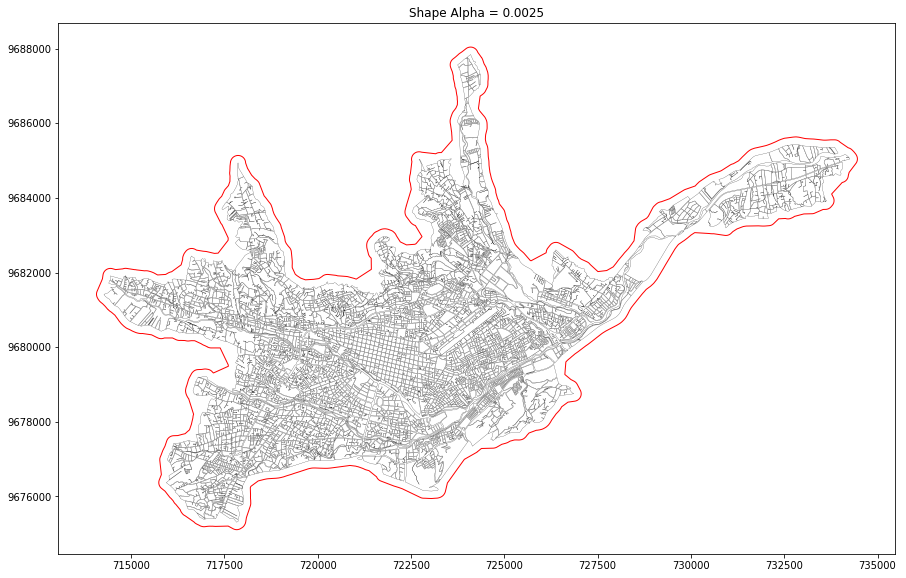

In [5]:
alpha = 0.0025
boundary = ms.boundary_from_areas(blocksGPD, alpha = alpha, buffer_dist=200)
base = blocksGPD.plot(color = 'white',edgecolor='black',linewidth=0.2,  figsize = (15,10))
base.set_title("Shape Alpha = {}".format(alpha))
boundary.plot(color = "None", edgecolor='red',linewidth=1, ax = base)
plt.show()

In [6]:
# turn polygon to geopandas data frame with projection
boundaryGPD = gpd.GeoDataFrame(geometry = boundary)
boundaryGPD.crs = crs_utm

## Create street network

Creates a time weighted graph that represents the street network with an average walking speed = 5Km/h.

* data source: OpenStreetMap, using OSMnx

In [7]:
street_network = ms.street_graph_from_boundary(boundaryGPD)

Generating street graph using OSMnx
created street network graph


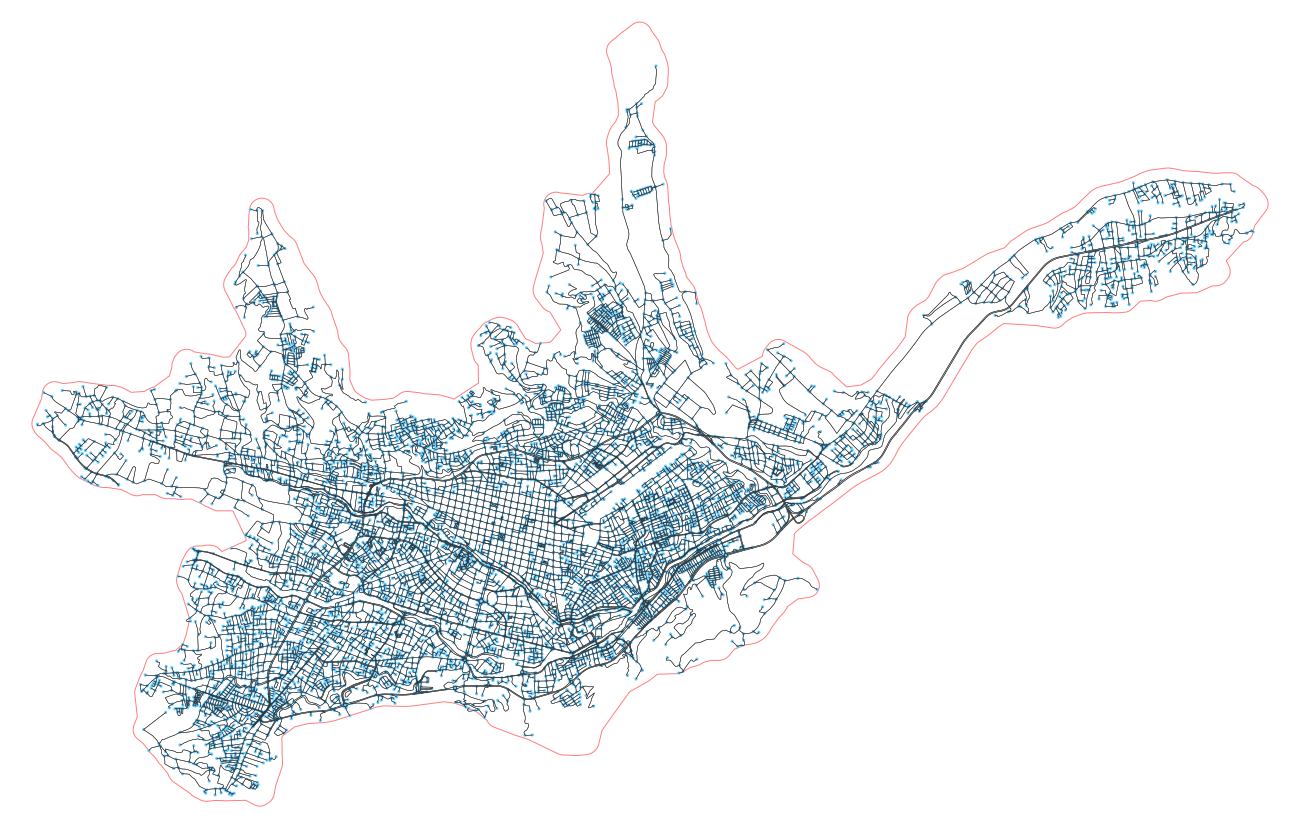

In [8]:
ms.plot_network(street_network, boundary)

## Create bus network

Creates a time weighted graph that represents the bus network with an average speed of = 30Km/h.

* data source: Municipality of Cuenca, Ecuador.

In [57]:
# creates bus network from lines and stops shape file
bus_network = ms.transport_graph_from_lines_stops(busLineGPD, 
                                                  busStopGPD, 
                                                  boundaryGPD, 
                                                  speed = 30,
                                                  group_lines_by = "LINEA",
                                                  group_stops_by = "lineNum",
                                                  lines_data = {"LINEA": "line", "RUTA":"route"},
                                                  stops_data = {'C2': 'name', 'N_líneas': 'number_of_lines'})

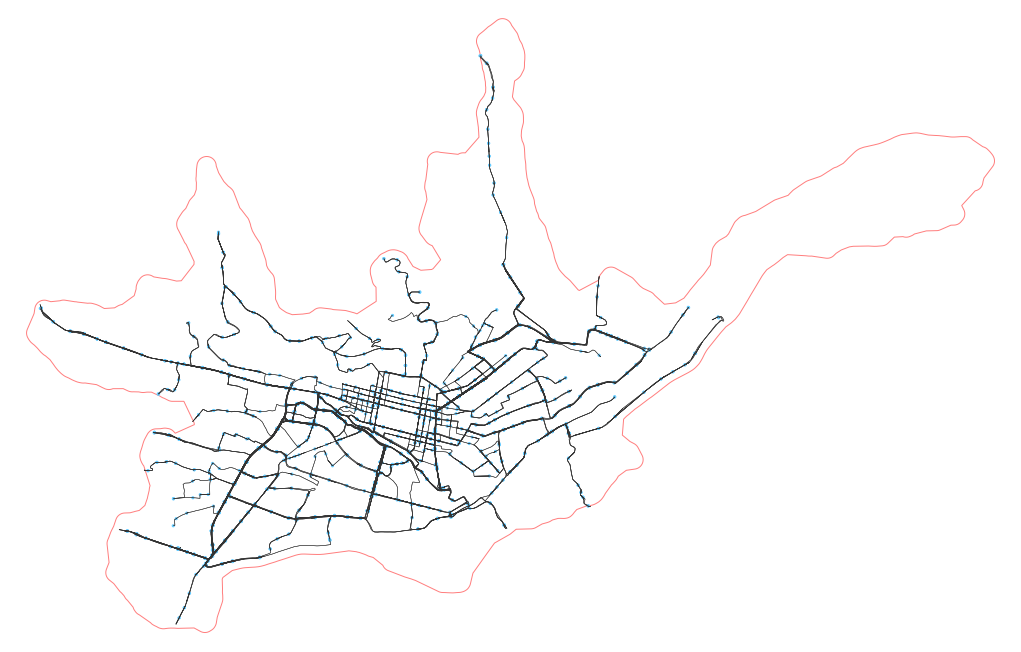

In [58]:
ms.plot_network(bus_network, boundary)

## Create tram network

Creates a time weighted graph that represents the tram network with an average speed of = 30Km/h.

* data source: Municipality of Cuenca, Ecuador.

In [11]:
# creates bus network from lines and stops shape file
bus_network = ms.transport_graph_from_lines_stops(tramLineGPD, 
                                                  tramStopGPD, 
                                                  boundaryGPD, 
                                                  speed = 40,
                                                  lines_data = {"LINEA": "line", "RUTA":"route"},
                                                  stops_data = {'C2': 'name', 'N_líneas': 'number_of_lines'})

In [59]:
tramLineGPD

,FID_,Entity,Layer,Color,Linetype,Elevation,LineWt,RefName,LONGITUD,geometry
0,0,LWPolyline,Eje2_Direccion2,1,Continuous,0.0,25,None,10.16870,LINESTRING Z (725116.172902533 9681228.9598672...
1,0,LWPolyline,Eje10_Direccion2,1,Continuous,0.0,25,None,0.37076,LINESTRING Z (719349.9746818901 9678903.752062...
2,0,LWPolyline,Eje11_Direccion1,3,Continuous,0.0,25,None,0.34332,LINESTRING Z (719025.5281999999 9679037.811000...
3,0,LWPolyline,Eje1_Direccion1,3,Continuous,0.0,25,None,10.16504,"LINESTRING Z (717990.122 9676943.589 0, 717970..."


In [13]:
stops = stopsGPD[stopsGPD.line_id == 0]

In [35]:
clean_bus

,line,route,geometry,grouped
0,2,TOTORACOCHA - ARENAL ALTO,LINESTRING (717169.0864000004 9677932.33599999...,2
1,2,FERIA LIBRE-ARENAL ALTO,LINESTRING (717164.8149657398 9677924.07145305...,2
2,3,LOS LIRIOS-EUCALIPTOS,LINESTRING (714285.419425357 9683573.086702231...,3
3,3,EUCALIPTOS-SAYAUSI( EL LIRIO),LINESTRING (714297.0584536734 9683569.57228693...,3
4,5,LOS ANDES-EL SALADO,LINESTRING (725467.0878512114 9680501.40564898...,5
5,5,EL SALADO-LOS ANDES,LINESTRING (717316.4501798293 9676971.40679977...,5
6,6,MERCADO 9 DE OCTUBRE,LINESTRING (721454.6068140123 9686149.46733482...,6
7,6,MAYANCELA,LINESTRING (721457.9326281644 9686152.58086601...,6
8,7,LOS TRIGALES-MALL DEL RIO,LINESTRING (719238.4728232175 9676750.60749930...,7
9,7,MALL DEL RIO-LOS TRIGALES,LINESTRING (719228.9478041669 9676766.48253105...,7


In [15]:
stops = stops.sort_values(by='at_length').reset_index()

In [29]:
stopsGPD

,Name,number_of_lines,geometry,grouped,at_length,line_id,id
0,Av. Manuel Cisneros y calle s/n - Barrio Arena...,1.0,POINT (717169.0864000004 9677932.335999999),2,0.000000,0,0
1,"Av. Paraíso y Av. 12 de Abril, Av. 12 de Abril...",5.0,POINT (722785.8567840263 9678133.18127987),2,7947.278752,0,1
2,Av. Carlos Arízaga y calle s/n - Cdla. Eloy Al...,2.0,POINT (717568.4710544607 9678298.309413519),2,729.609064,0,2
3,Av. 12 de Abril,3.0,POINT (722511.4537313429 9678342.020639773),2,7534.124460,0,3
4,"Av. Carlos Arízaga Toral y Tarquino Cordero, T...","2.0, 1.0",POINT (717943.8441939867 9678345.115014093),2,1138.779393,0,4
5,Av. 12 de Abril y Federico Malo,6.0,POINT (721958.4241903633 9678877.799503941),2,6753.940798,0,5
6,Av. Huayna Cápac y Cacique Chaparra,5.0,POINT (722696.9024681589 9678662.209200518),2,8483.928856,0,6
7,Primero de Mayo y Carmela Malo,1.0,POINT (717990.9575701928 9678671.555169489),2,1505.399165,0,7
8,"Av. 12 de abril, Av. 12 de Abril",3.0,POINT (722403.9709810201 9678484.500354784),2,7355.630073,0,8
9,"Carmela Malo y Jaime Maldonado, Camino a Misic...",1.0,POINT (717918.1051086147 9678517.388882613),2,1333.719678,0,9


In [238]:
for i, point in stops[:-1].iterrows():
    pId = i
    pId2 = i+1
    
    dist1 = point.at_length
    dist2 = stops.at_length[i+1]
    
    length = dist2-dist1
    print(length)

729.6090636730574
409.17032970018215
194.94028447713004
171.67948707198707
188.54904885990527
444.57251821104546
251.6111911863004
394.4886537662974
581.7848315262208
405.31876865943696
269.1785016801573
183.43711668445167
115.55175607228375
340.481617495454
152.41876672364015
207.8573992601996
164.2248362766768
156.29585396336006
357.4079698897749
281.25400204766265
387.6072086355589
366.50159256452935
601.6892747696602
178.49438701332292
413.1542919510903
432.42893807047585
104.22116595130501
308.15371939777833
382.0869389263971
354.6178562610985
158.90168784714297
185.87341990771165
206.507023322647
417.0507853400759
319.3308984256819
296.5608005721915
536.0152500165768
379.80172100283926
600.0115099153209
239.18418952432148
222.54486296199866
332.334495382911


In [240]:
coords = list(clean_bus.geometry[0].coords)

In [16]:
line = clean_bus.geometry[0]

In [22]:
res = ms.cut_line(line, 5000)

In [25]:
clean_bus.columns

[autoreload of multiseg.multiplexSeg failed: Traceback (most recent call last):
  File "c:\users\malvarez\appdata\local\continuum\miniconda3\envs\py36\lib\site-packages\IPython\extensions\autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\malvarez\appdata\local\continuum\miniconda3\envs\py36\lib\site-packages\IPython\extensions\autoreload.py", line 376, in superreload
    module = reload(module)
  File "c:\users\malvarez\appdata\local\continuum\miniconda3\envs\py36\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "c:\users\malvarez\appdata\local\continuum\miniconda3\envs\py36\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741

Index(['line', 'route', 'geometry', 'grouped'], dtype='object')

In [26]:
stopsGPD

,Name,number_of_lines,geometry,grouped,at_length,line_id
0,Av. Manuel Cisneros y calle s/n - Barrio Arena...,1.0,POINT (717169.0864000004 9677932.335999999),2,0.000000,0
1,"Av. Paraíso y Av. 12 de Abril, Av. 12 de Abril...",5.0,POINT (722785.8567840263 9678133.18127987),2,7947.278752,0
2,Av. Carlos Arízaga y calle s/n - Cdla. Eloy Al...,2.0,POINT (717568.4710544607 9678298.309413519),2,729.609064,0
3,Av. 12 de Abril,3.0,POINT (722511.4537313429 9678342.020639773),2,7534.124460,0
4,"Av. Carlos Arízaga Toral y Tarquino Cordero, T...","2.0, 1.0",POINT (717943.8441939867 9678345.115014093),2,1138.779393,0
5,Av. 12 de Abril y Federico Malo,6.0,POINT (721958.4241903633 9678877.799503941),2,6753.940798,0
6,Av. Huayna Cápac y Cacique Chaparra,5.0,POINT (722696.9024681589 9678662.209200518),2,8483.928856,0
7,Primero de Mayo y Carmela Malo,1.0,POINT (717990.9575701928 9678671.555169489),2,1505.399165,0
8,"Av. 12 de abril, Av. 12 de Abril",3.0,POINT (722403.9709810201 9678484.500354784),2,7355.630073,0
9,"Carmela Malo y Jaime Maldonado, Camino a Misic...",1.0,POINT (717918.1051086147 9678517.388882613),2,1333.719678,0


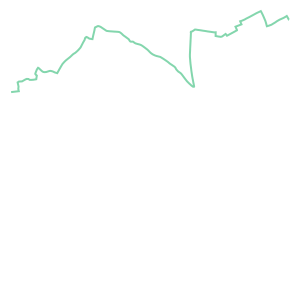

In [21]:
line

In [75]:
from multiseg import *
tolerance = 20
for group in lines.grouped.unique():
    lines_subset = lines[lines.grouped == group]

    # loop through individual geometries
    for i, row in lines_subset.iterrows():
        print(group, i)
        geom = row.geometry

        # check if line is MultiLineString
        if isinstance(geom, geometry.MultiLineString):
            geom_list = geom.geoms

            # create empty list to store coordinates of line
            lines_coords = []
            for line in geom_list:
                # if line is not smaller than tolerance meters and not a self-loop
                if line.length > tolerance and line.coords[0] != line.coords[-1]:
                    coord_list = list(line.coords)
                    lines_coords.append(coord_list)

            # choose first line and look for continuation
            line_coord = lines_coords[0]
            line_list = lines_coords[1:]

            line_joined = join_lines(line_coord, line_list)
            line_joined = join_lines(list(reversed(line_joined)), line_list)

            line_geom = geometry.LineString(coor for coor in line_joined)

        else:
            line_geom = geom

        lines_list.append(line_geom)

2 0
2 1
3 2
3 3


TypeError: 'NoneType' object is not iterable

In [85]:
if isinstance(geom, geometry.MultiLineString):
    geom_list = geom.geoms

    # create empty list to store coordinates of line
    lines_coords = []
    for line in geom_list:
        # if line is not smaller than tolerance meters and not a self-loop
        if line.length > tolerance and line.coords[0] != line.coords[-1]:
            coord_list = list(line.coords)
            lines_coords.append(coord_list)

    # choose first line and look for continuation
    line_coord = lines_coords[0]
    line_list = lines_coords[1:]

    line_joined = join_lines(line_coord, line_list)
    line_joined = join_lines(list(reversed(line_joined)), line_list)

    line_geom = geometry.LineString(coor for coor in line_joined)

In [83]:
line_joined = join_lines(list(reversed(line_joined)), line_list)

TypeError: 'NoneType' object is not reversible

In [84]:
line_list

[]

In [32]:
geom_list = geom.geoms

In [56]:
for line in geom_list:
    # if line is not smaller than tolerance meters and not a self-loop
    if line.length > 20 and line.coords[0] != line.coords[-1]:
        coord_list = list(line.coords)
        lines_coords.append(coord_list)

# choose first line and look for continuation
line_coord = lines_coords[0]
line_list = lines_coords[1:]

In [57]:
line_joined = ms.join_lines(line_coord, line_list)

In [58]:
line_joined = ms.join_lines(list(reversed(line_joined)), line_list)

In [62]:
line_geom = ms.geometry.LineString(coor for coor in line_joined)

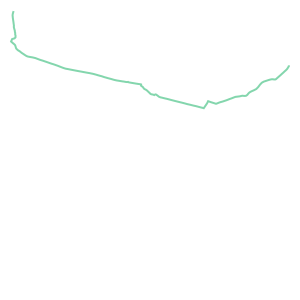

In [63]:
line_geom

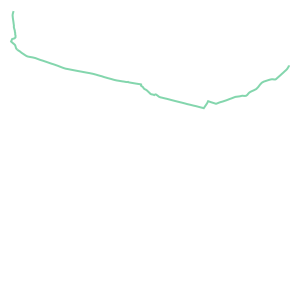

In [65]:
geom

In [72]:
line = bus_lines.geometry[3]
isinstance(line, ms.geometry.MultiLineString)
lgeos = line.geoms

lines = []
for tl in lgeos:
    tlines = []
    if tl.length > 20 and tl.coords[0] != tl.coords[-1]:
        coord = list(tl.coords)
        lines.append(coord)

In [78]:
list_= [1,2,3,4]
list_
    

[1, 2, 3, 4]

In [79]:
list_.remove(3)
list_

[1, 2, 4]

In [53]:
lines_list = []
for lineNum in busLineGPD.LINEA.unique():
    bus_lines = busLineGPD[busLineGPD.LINEA == lineNum]
    for i, bus_line in bus_lines.iterrows():
        line = bus_line.geometry
        #check if line is multilinestring to store as multiple singlelinesstrings
        if isinstance(line, ms.geometry.MultiLineString):
            print(lineNum, i)
            break
            lgeos = line.geoms
            lines = []
            for tl in lgeos:
                tlines = []
                if tl.length > 20 and tl.coords[0] != tl.coords[-1]:
                    coord = list(tl.coords)
                    for j in range(len(coord)):
                        point = coord[j]
                        tlines.append(point)
                    lines.append(coord)
            #choose first line and look for continuation
            lineCoord = lines[0]
            lineList = lines[1:]
            lineJoin = join_lines(lineCoord, lineList)
            lineJoin = join_lines(list(reversed(lineJoin)), lineList)
            tlines = geometry.LineString(coor for coor in lineJoin)
            linesGPD = gpd.GeoDataFrame({'nline': [bus_line.LINEA],
                                         'way': [bus_line.TRAYECTO],
                                         'route': [bus_line.RUTA],
                                         'geometry': [tlines],
                                         'ngeom': [1],
                                       })
        else:
            linesGPD = gpd.GeoDataFrame({'nline': [bus_line.LINEA],
                                         'way': [bus_line.TRAYECTO],
                                         'route': [bus_line.RUTA],
                                         'geometry': [line],
                                         'ngeom': [1]
                                       })

        lines_list.append(linesGPD)
res = gpd.GeoDataFrame(pd.concat(lines_list, ignore_index=True))
return res

3 3
6 7
12 12
18 23
23 31
25 33
27 37


SyntaxError: 'return' outside function (<ipython-input-53-7ccbb555db72>, line 42)

In [203]:
busStopGPD.to_file("bus_stops.shp")